In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# 1. 데이터 로드 및 전처리
# 신용카드 데이터셋을 불러옵니다.

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WISDM.csv', header = None, index_col = 0)

In [4]:
df

,1,2,3,4,5,6
0,,,,,,
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1048571,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048572,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048573,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000


In [5]:
df = df.set_axis(labels=['user','activity','timestamp','x','y','z'],axis=1)

In [6]:
df

,user,activity,timestamp,x,y,z
0,,,,,,
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1048571,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048572,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048573,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000


In [7]:
df.shape

(1048575, 6)

In [8]:
# 결측치 홗인

df.isnull().values.any()

np.False_

In [9]:
LABELS = ["Jogging", "Sitting"]

In [10]:
new_df = df[df['activity'].isin(['Jogging', 'Sitting'])]
new_df = new_df.drop('user', axis = 1)
new_df = new_df.drop('timestamp', axis = 1)

In [11]:
new_df

,activity,x,y,z
0,,,,
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1036606,Jogging,1.420000,-2.340000,1.950000
1036607,Jogging,-0.800000,0.230000,0.950000
1036608,Jogging,-0.110000,9.110000,-0.930000


/tmp/ipython-input-1778102342.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(new_df['activity'], sort = True)


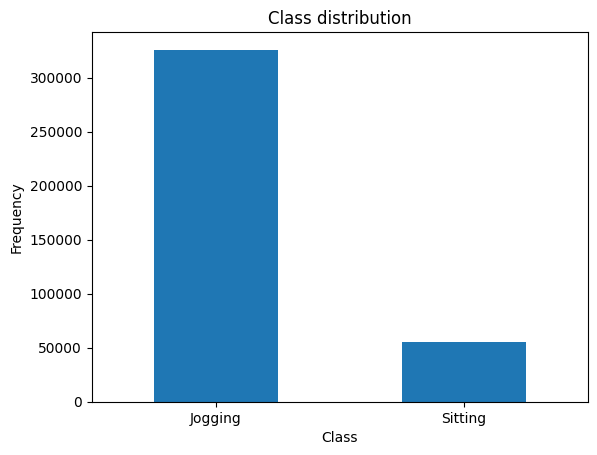

In [12]:
count_classes = pd.value_counts(new_df['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [13]:
from sklearn.preprocessing import StandardScaler

new_df['x'] = StandardScaler().fit_transform(new_df['x'].values.reshape(-1, 1))
new_df['y'] = StandardScaler().fit_transform(new_df['y'].values.reshape(-1, 1))
new_df['z'] = StandardScaler().fit_transform(new_df['z'].values.reshape(-1, 1))

In [14]:
abnormal = new_df[new_df.activity == "Sitting"]
normal = new_df[new_df.activity == "Jogging"]
abnormal.shape

(54876, 4)

In [15]:
normal.shape

(325975, 4)

In [16]:
# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

In [17]:
RANDOM_SEED = 42

In [18]:
X_train, X_test = train_test_split(new_df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.activity == "Jogging"]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(260847, 3)

In [19]:
# 테스트 레이블을 남겨두는 이유는 나중에 정확도를 비교하기 위해서임

In [28]:
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 20  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [29]:
# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          validation_split = 0.1)


Epoch 1/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2257 - val_loss: 5.7483e-04
Epoch 2/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.7014e-04 - val_loss: 1.0476e-04
Epoch 3/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.8498e-05 - val_loss: 4.6137e-05
Epoch 4/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.9572e-05 - val_loss: 1.5058e-05
Epoch 5/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.2115e-06 - val_loss: 1.3275e-05
Epoch 6/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.8113e-06 - val_loss: 3.3795e-06
Epoch 7/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.7521e-06 - val_loss: 6.1619e-06
Epoch 8/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.8057e-06 - val_loss: 6.7314e-07
Epoch 9/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.4650e-06 - val_loss: 2.0460e-05
Epoch 10/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.2016e-06 - val_loss: 1.4492e-05
Epoch 11/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 

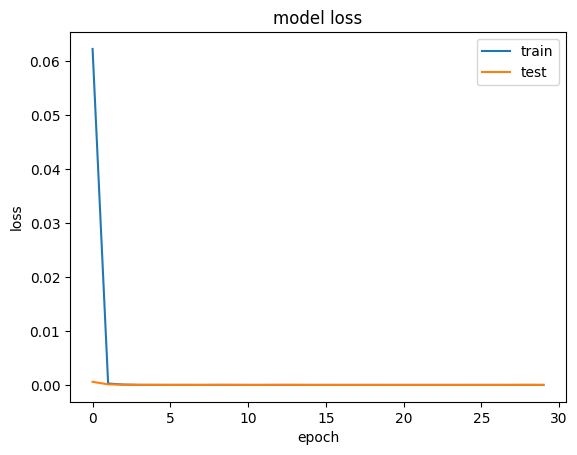

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [31]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2381/2381 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


,reconstruction_error
count,7.617100e+04
mean,6.109992e-07
std,5.330592e-06
min,7.085683e-11
25%,1.150031e-07
50%,2.580859e-07
75%,6.002294e-07
max,1.349034e-03


In [32]:
error_df

,reconstruction_error,true_class
0,,
106873,2.405341e-08,Jogging
125283,5.055998e-08,Jogging
634104,7.279147e-07,Jogging
198929,2.106800e-07,Jogging
422862,2.934607e-08,Jogging
...,...,...
548291,2.361825e-07,Jogging
110505,1.593918e-07,Jogging
199869,2.797400e-06,Jogging


In [52]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정

threshold = 0.000001

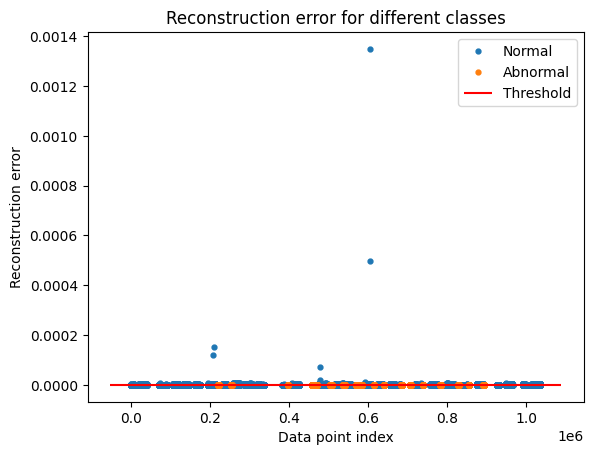

In [53]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == "Sitting" else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

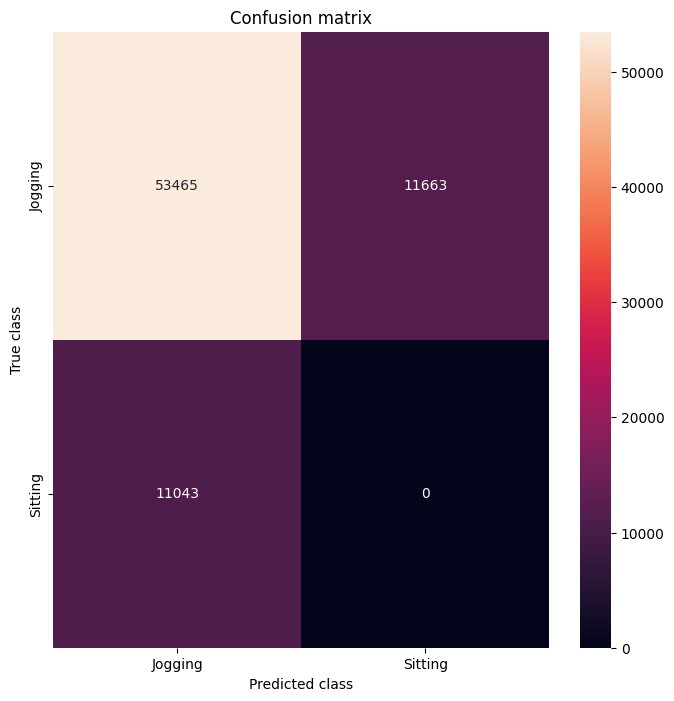

              precision    recall  f1-score   support

     Jogging       0.83      0.82      0.82     65128
     Sitting       0.00      0.00      0.00     11043

    accuracy                           0.70     76171
   macro avg       0.41      0.41      0.41     76171
weighted avg       0.71      0.70      0.71     76171



In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = ['Sitting' if e > threshold else 'Jogging' for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))